# Validating generator performance notebook (unconditional case).

In this notebook, we validate the performance of a given generator model $G_\theta$ against a specified path bank. In this way we are seeking to evaluate the performance of the generated measure $\mathbb{P}_\theta$ against the real data measure $\mathbb{P}^r$. 

Naturally choosing a (differentiable) distance on the space these two objects reside on is one of the crucial decisions in GAN training, i.e. MMD, Wasserstein metric, KL, and so on. Here we choose a few metrics that are not the same as those used to train any of the models. We study the following - 

1) Qualitative plot of marginals of $\mathbb{P}_\theta$ against $\mathbb{P}^r$, for level values, returns, and squared returns,

2) Kolmogorov-Smirnov score and associated p-value for specified marginals between $\mathbb{P}_\theta$ and $\mathbb{P}^r$, 

3) Autocorrelation (ACF) plot of levels and returns for real and generated paths, 

4) Cross-covariance matrices for level, returns and squared returns.

In [1]:
import torch
import torch.optim.swa_utils as swa_utils
from scipy import stats as st
import matplotlib.pyplot as plt
import scienceplots
import numpy as np
import seaborn as sns
import pandas as pd
from statsmodels.tsa.stattools import acf

from src.rBergomi import rBergomi
from src.gan import sde
from src.gan.generators import Generator
from src.gan.base import preprocess_real_data, get_real_data, get_synthetic_data
from src.utils.helper_functions.data_helper_functions import subtract_initial_point
from src.utils.helper_functions.global_helper_functions import get_project_root
from src.utils.helper_functions.plot_helper_functions import make_grid
from src.evaluation_functions import get_ccor_matrix, generate_ks_results

plt.style.use('science')
plt.rcParams['axes.titlesize']  = 24
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize']  = 22

GOLDEN_RATIO = (1 + np.sqrt(5))/2

In [2]:
is_cuda = torch.cuda.is_available()
device = 'cuda' if is_cuda else 'cpu'

if not is_cuda:
    print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")
    
# You realistially need GPU access (either natively or via cloud computing) to run this notebook.

## 0. Load generator and required data

We first load the generator and data we wish to test against.

In [3]:
output_dim          = 1               # Dimension of the outputs.
batch_size          = 128             # Sample size when evaluating.
eval_batch_size     = 128
path_length         = 64              # Number of timesteps in paths.
dataset_size        = 8192            # Number of paths in the train/test datasets.
normalisation       = "mean_var"      # How to transform paths. Options are None, "mean_var", "min_max"
scale               = 1e0             # Float scale to each path dimension.

## Data generation/dataset arguments
data_type             = "gbm"                           # Choice of "gbm", "rBergomi", "forex".

forex_pairs           = ["EURUSD", "USDJPY"]            # "EURUSD", "USDJPY", "BTCUSD", "BRENTCUSD"
stride_length         = 8                               # Number of timesteps to stride when creating path data.
frequency             = "H1"                            # Choice of "H1", "M15", "M30"
filter_extremal_paths = False                           # Filter out extremal values (by tv and terminal value)
filter_extremal_pct   = 0.95                            # Quantile to filter out, if the above is TRUE
end_time              = 2

sde_parameters           = [0., 0.2] if data_type =="gbm" else [0.2**2, 1.5, -0.7, 0.2]
# If data_type is "gbm" or "rBergomi", parameters for model
gen_sde_dt_scale         = 1e-2                            # Refine the partitioning of SDE solver that generates data.
gen_sde_integration_type = "ito"                           # Definition of stochastic integration for data generator
gen_sde_method           = "srk"                           # Integration method

learning_type            = "paths"                         # Paths or returns.
time_add_type            = "basic"                         # "Basic": (0, 1, ...). "Realistic": actual change (in years)
filter_by_time           = False                           # Whether to filter out some paths on end time.
initial_point            = "scale"

In [4]:
data_kwargs = {
    "dataset_size" : dataset_size,
    "path_length"  : path_length,
    "batch_size"   : batch_size,
    "step_size"    : stride_length,
    "learning_type": learning_type,
    "time_add_type": time_add_type,
    "initial_point": initial_point
}

real_data_kwargs = {
    "pairs"                : forex_pairs,
    "frequency"            : frequency,
    "filter_extremal_paths": filter_extremal_paths,
    "filter_extremal_pct"  : filter_extremal_pct
    
}

if data_type.lower() == "forex":  # Real data arguments
    np_train_data, np_test_data = preprocess_real_data(data_kwargs, real_data_kwargs)
    
    ts, data_size, dataloader = get_real_data(
        np_train_data, 
        batch_size, 
        dataset_size, 
        device, 
        time_add_type  = time_add_type, 
        normalisation  = normalisation,
        filter_by_time = filter_by_time,
        initial_point  = False,
        scale          = scale
    )

elif data_type.lower() in ["gbm", "rbergomi"]:
    
    sdeint_kwargs = {
        "sde_method":   gen_sde_method,
        "sde_dt_scale": gen_sde_dt_scale
    }
    
    if data_type.lower() == "gbm":
        sde_gen = sde.GeometricBrownianMotion(gen_sde_integration_type, "diagonal", *sde_parameters)
    elif data_type.lower() == "rbergomi":
        xi, eta, rho, H = sde_parameters
        sde_gen = rBergomi(n=int(path_length/end_time), N=dataset_size, T=end_time, a=H-0.5, rho=rho, eta=eta, xi=xi)
    
    ts, data_size, dataloader = get_synthetic_data(
        sde_gen,
        eval_batch_size,
        dataset_size,
        device,
        output_dim,
        path_length,
        normalisation = normalisation,
        scale         = scale,
        sdeint_kwargs = sdeint_kwargs,
        end_time      = end_time,
        time_add_type = time_add_type
    )
    
infinite_dataloader = (elem for it in iter(lambda: dataloader, None) for elem in it)

In [6]:
# Load generator
discriminator_types = ["sigker_mmd", "truncated_mmd", "wasserstein_cde"]
averaged_model      = False
generators          = []

for discriminator_type in discriminator_types:
    generator_fp       = get_project_root().as_posix() + f"/saved_models/generators/{data_type}_{path_length}_{batch_size}_{output_dim}_{discriminator_type}"

    generator_state_dict          = torch.load(generator_fp + ".pkl")
    averaged_generator_state_dict = torch.load(generator_fp + "_averaged.pkl")
    generator_config              = torch.load(generator_fp + "_config.pkl")

    generator = Generator(data_size=data_size, **generator_config).to(device)

    if averaged_model:
        generator = swa_utils.AveragedModel(generator)
        generator.load_state_dict(averaged_generator_state_dict)
    else:
        generator.load_state_dict(generator_state_dict)
        
    generators.append(generator)

In [7]:
# Load some sample paths, perform transformations, put onto the cpu 
real_samples,     = next(iter(dataloader))
real_samples      = subtract_initial_point(real_samples).detach().cpu()

dims              = int(real_samples.size(-1) - 1)

total_generated_samples = torch.zeros([3] + list(real_samples.size()))

for i, generator in enumerate(generators):
    total_generated_samples[i] = subtract_initial_point(generator(ts, eval_batch_size)).detach().cpu()

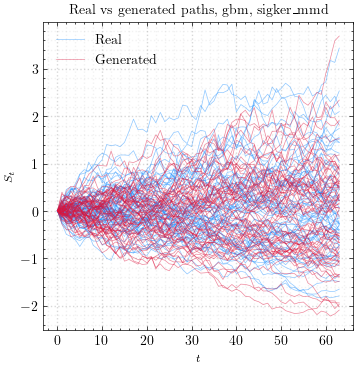

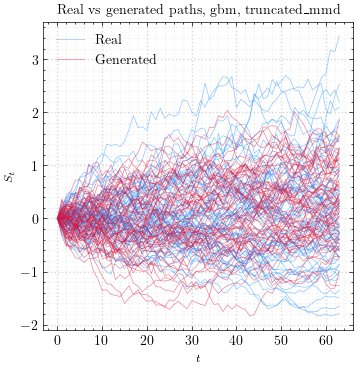

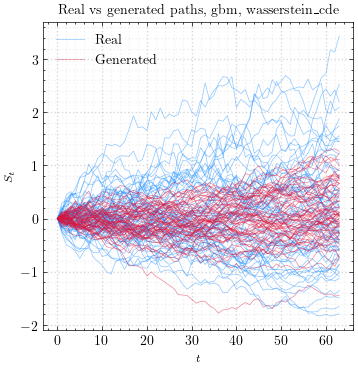

In [8]:
num_plot_samples = 64
height = 4

real_plot_samples = real_samples[..., 1:]
real_plot_samples = real_plot_samples[:num_plot_samples]

for generated_samples, discriminator_type in zip(total_generated_samples, discriminator_types):
        
    with torch.no_grad():
        generated_plot_samples = generated_samples.cpu()[..., 1:]

    generated_plot_samples = generated_plot_samples[:num_plot_samples]
    
    for k in range(dims):
        fig, ax = plt.subplots(1, 1, figsize=(height, height))
        
        real_first = True
        generated_first = True
        for real_sample_ in real_plot_samples[..., k]:
            kwargs = {'label': 'Real'} if real_first else {}
            ax.plot(ts.cpu(), real_sample_.cpu(), color='dodgerblue', linewidth=0.5, alpha=0.5, **kwargs)
            real_first = False
        for generated_sample_ in generated_plot_samples[..., k]:
            kwargs = {'label': 'Generated'} if generated_first else {}
            ax.plot(ts.cpu(), generated_sample_.cpu(), color='crimson', linewidth=0.5, alpha=0.5, **kwargs)
            generated_first = False
        ax.legend()
        ax.set_xlabel("$t$", fontsize="small")
        ax.set_ylabel("$S_t$", fontsize="small")
        make_grid(axis=ax)
        
        if data_type == "forex":
            label = forex_pairs[k]
        else:
            label = data_type
            
        ax.set_title(f"Real vs generated paths, {label}, {discriminator_type}", fontsize=10)
#plt.tight_layout()

## 1. Qualitative plot of marginals: $S_t, r_t, r^2_t$

We first give a plot of the marginals at specified times. This gives a qualitative indication to model performance.

In [9]:
def plot_histograms(gen_vals, real_vals, marginals, figsize=(10, 5), title=""):
    
    n_marginals = len(marginals)
    
    fig, axes = plt.subplots(1, n_marginals, figsize=figsize)
    
    n_paths, length = gen_vals.size()
    length += 1
    n_bins = min(int(n_paths/10), 100)
    
    for ii, (ax, marg) in enumerate(zip(axes, marginals)):
        gen_slice = gen_vals[:, ii]
        real_slice = real_vals[:, ii]
        
        ax.hist(
            real_slice, bins=n_bins, alpha=0.5, label='Real' if ii == 0 else "", 
            color='dodgerblue', histtype="bar", stacked=True, edgecolor=None, density=True)
        ax.hist(
            gen_slice, bins=n_bins, alpha=0.5, label='Generated' if ii == 0 else "", 
            color='tomato', histtype="bar", stacked=True, edgecolor=None, density=True)
        
        if ii == 0:
            ax.legend(loc="upper left", fontsize="small")
        
        ax.set_ylabel('density')
        make_grid(axis=ax)
        
        ax.set_title(f'Marginal distribution at time {int(marg*length)}, ' + title, fontsize=10)
    plt.tight_layout()
    plt.show()

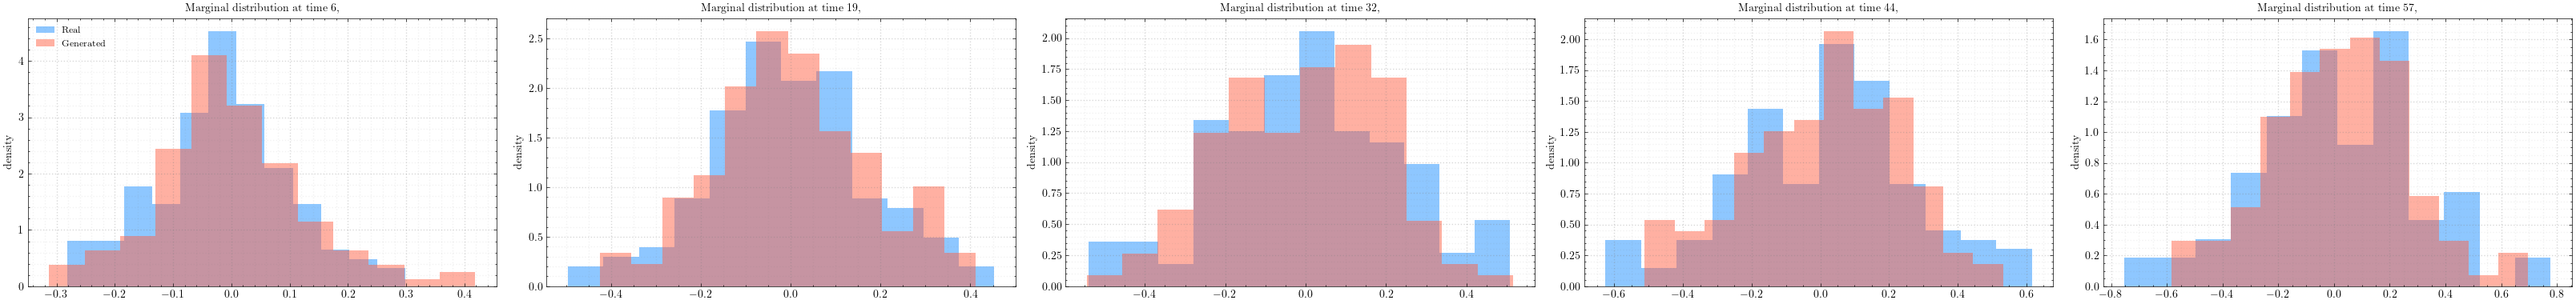

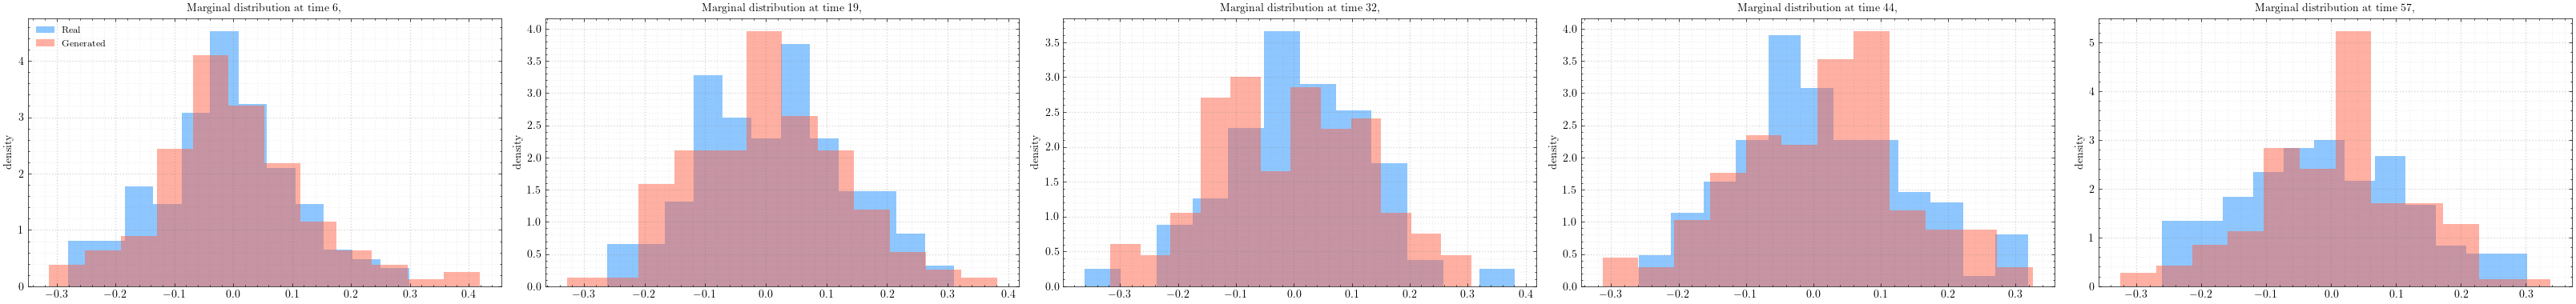

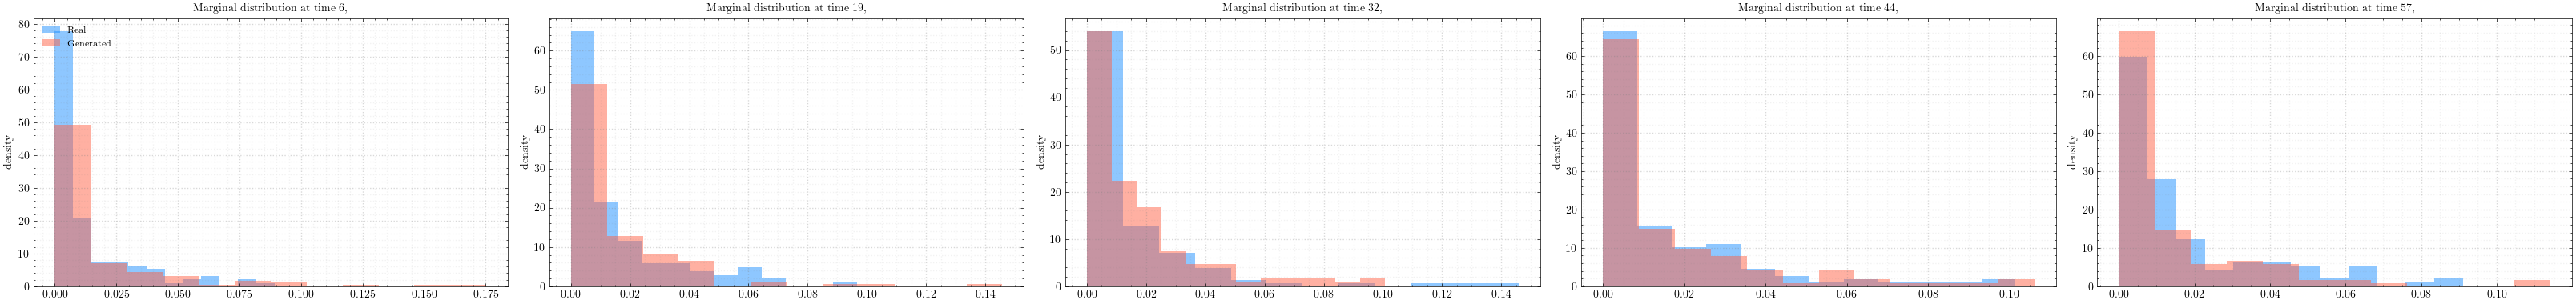

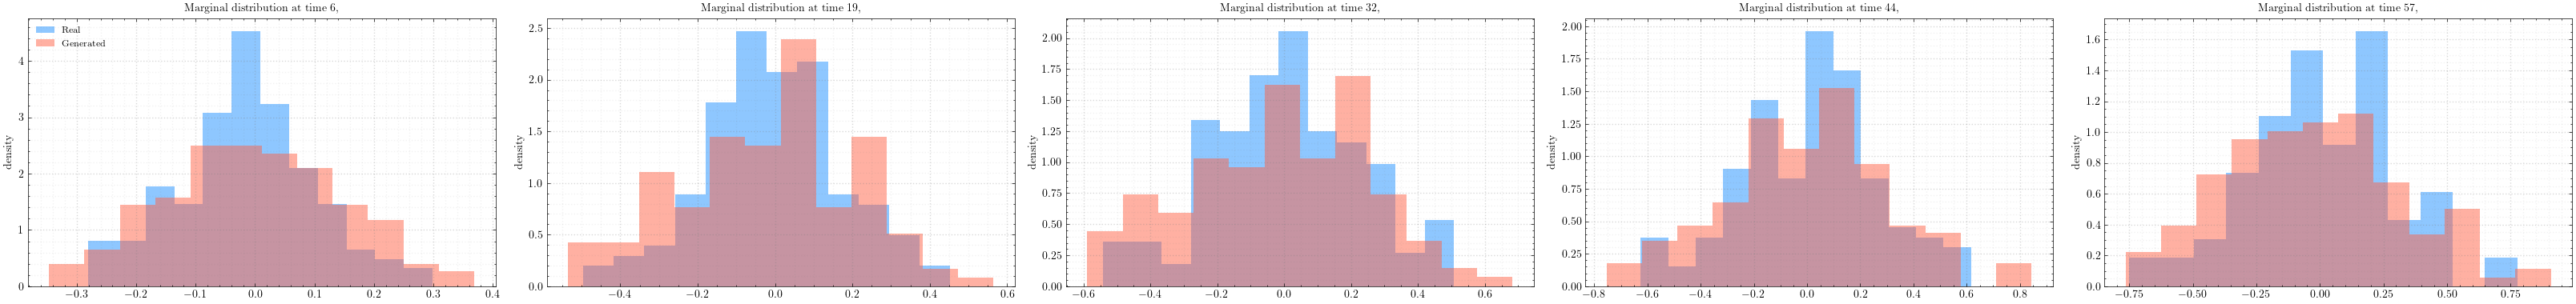

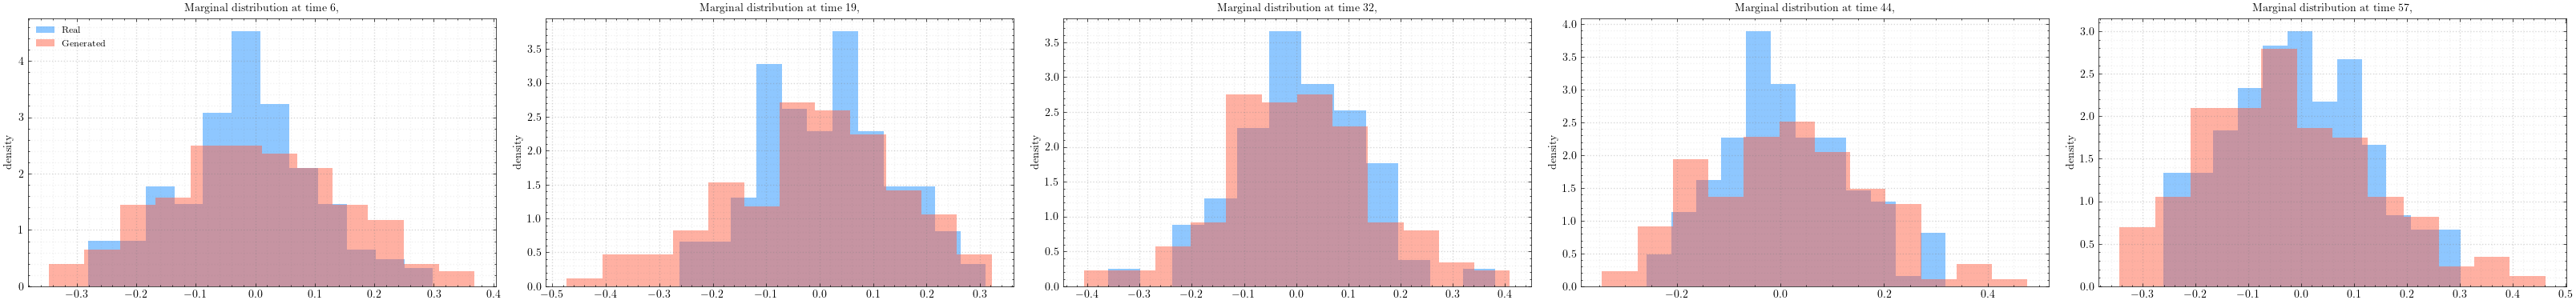

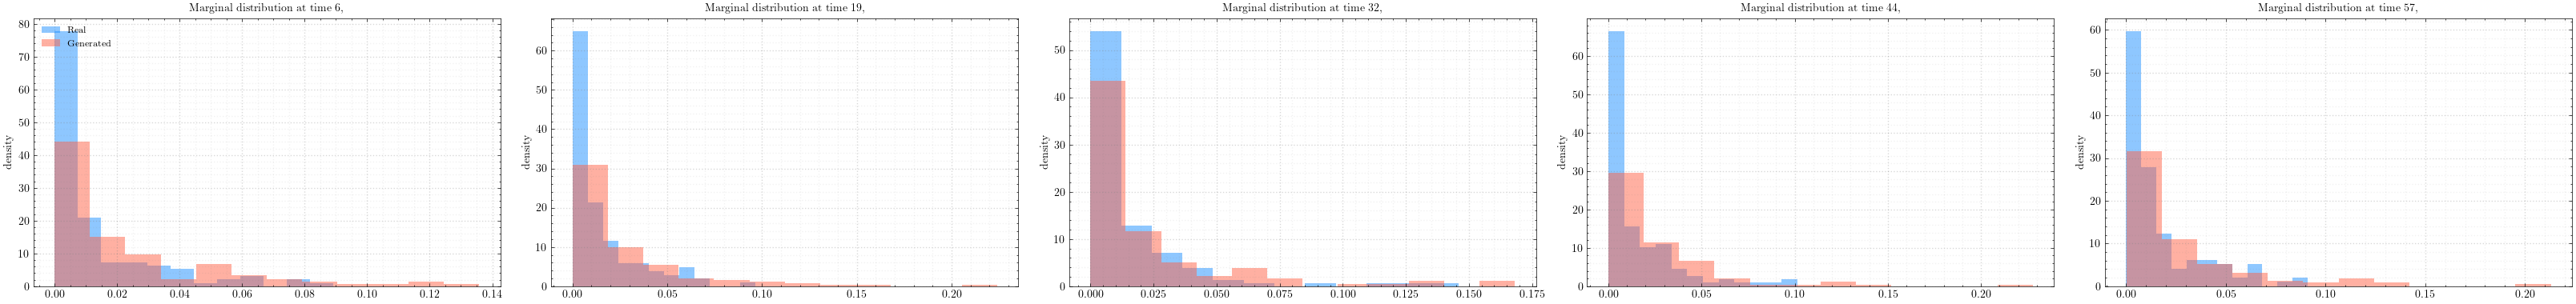

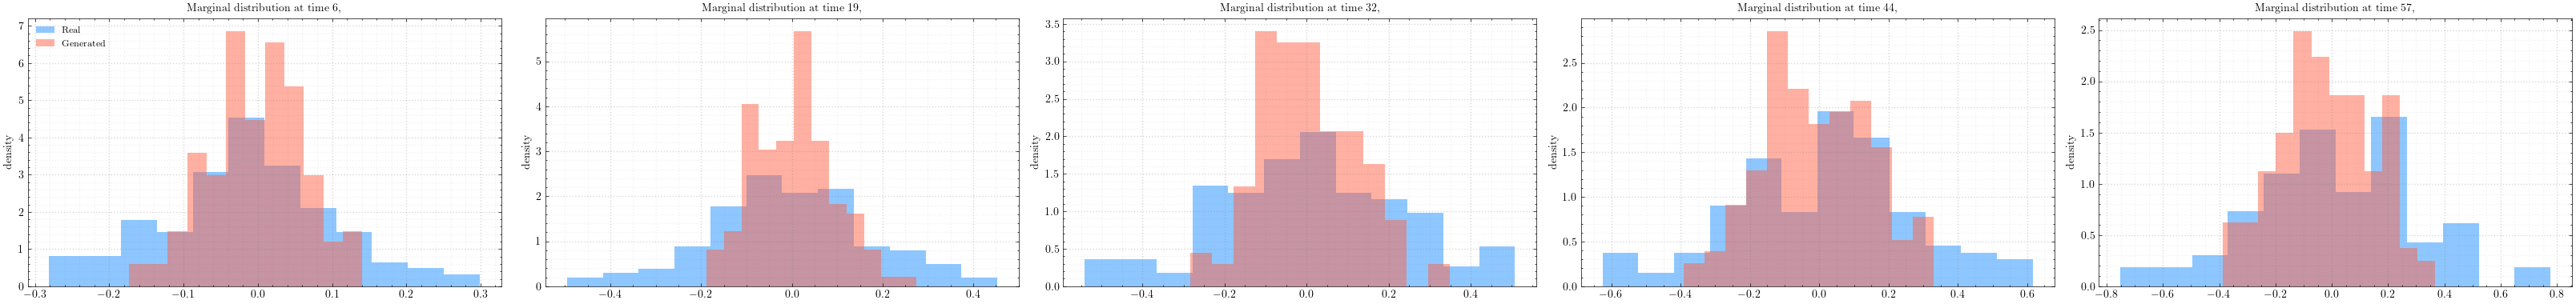

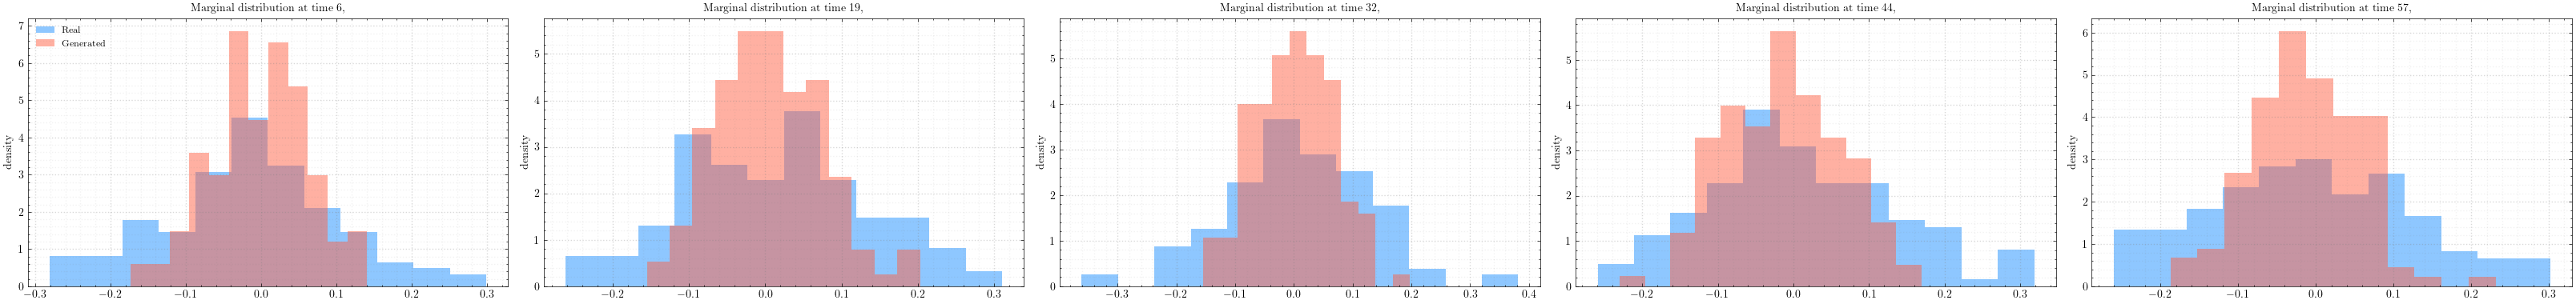

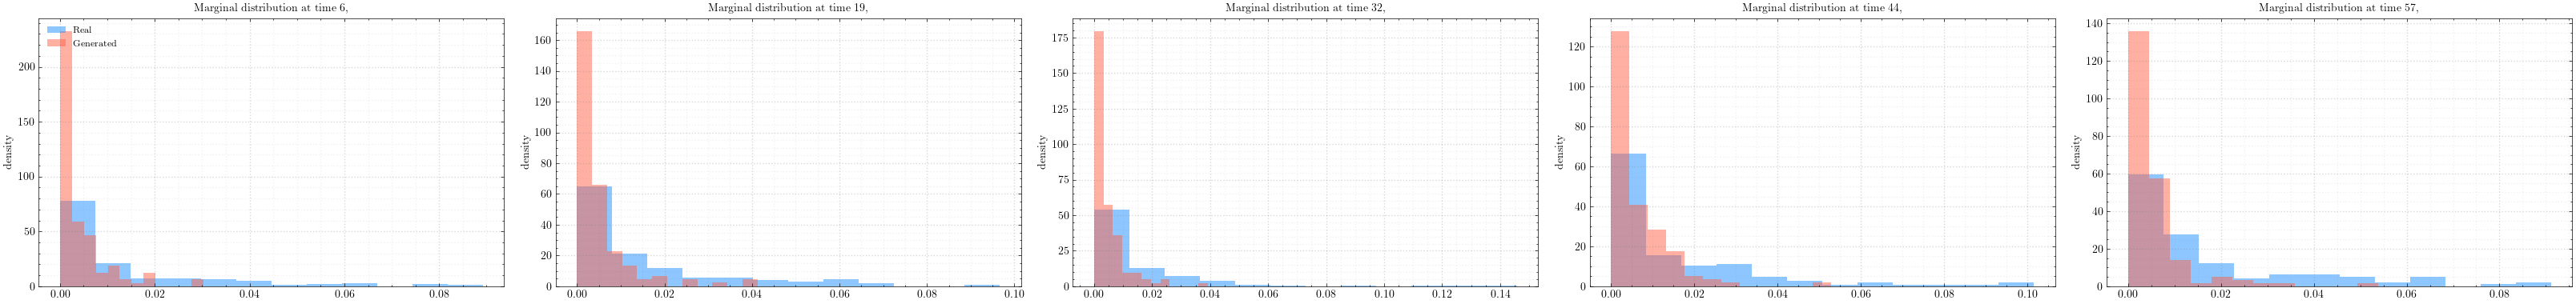

In [10]:
pct_marginals = (0.1, 0.3, 0.5, 0.7, 0.9)
height = 4
figsize = (height*GOLDEN_RATIO*len(pct_marginals), height)
marginals = [int(path_length*pcm) for pcm in pct_marginals]

for generated_samples in total_generated_samples:
    for k in range(dims):
        generated_levels  = generated_samples[:, 1:, k+1]
        generated_rets    = torch.diff(generated_samples[..., k+1], axis=1)
        generated_ret_sqs = torch.pow(generated_rets, 2)

        real_levels  = real_samples[:, 1:, k+1]
        real_rets    = torch.diff(real_samples[..., k+1], axis=1)
        real_ret_sqs = torch.pow(real_rets, 2)
        
        title = forex_pairs[k] if data_type == "forex" else ""

        plot_histograms(generated_levels, real_levels  , pct_marginals, figsize=figsize, title=title)
        plot_histograms(generated_rets, real_rets      , pct_marginals, figsize=figsize, title=title)
        plot_histograms(generated_ret_sqs, real_ret_sqs, pct_marginals, figsize=figsize, title=title)

## 2. Kolmogorov-Smirnov $p$-values

We now report the Kolmogorov-Smirnov test statistic (and $p$-values) between the generated paths and real paths at given marginals.

In [13]:
from scipy.stats import ks_2samp

marginals = (0.1, 0.3, 0.5, 0.7, 0.9)
alpha     = 0.95
tol       = 1 - alpha
n_runs    = 1000

In [14]:
total_ks_results = generate_ks_results(
    ts, infinite_dataloader, generators, marginals, n_runs, dims=dims, eval_batch_size=eval_batch_size
)

for k in range(dims):
    print(f"Dimension: {k+1}")
    for i, m in enumerate(marginals):
        print(f"Marginal {int(path_length*m)}:")

        for j, disc in enumerate(discriminator_types):

            average_score  = np.mean(total_ks_results[j, :, k, i, 0])
            std_score      = np.std(total_ks_results[j, :, k, i, 0])
            percent_reject = sum(total_ks_results[j, :, k, i, 1] <= tol)/n_runs

            lci, hci = st.norm.interval(confidence=alpha, loc=average_score, scale=std_score)

            print(f"{disc}: Average KS score: {average_score:.4f}, " 
                  f"% reject: {percent_reject*100:.1f}, CI: {lci:.4f}, {hci:.4f}")
        print("")

Dimension: 1
Marginal 6:
sigker_mmd: Average KS score: 0.1082, % reject: 6.3, CI: 0.0426, 0.1739
truncated_mmd: Average KS score: 0.1346, % reject: 19.2, CI: 0.0581, 0.2111
wasserstein_cde: Average KS score: 0.2066, % reject: 84.2, CI: 0.1324, 0.2809

Marginal 19:
sigker_mmd: Average KS score: 0.1065, % reject: 5.4, CI: 0.0397, 0.1732
truncated_mmd: Average KS score: 0.1293, % reject: 17.1, CI: 0.0493, 0.2094
wasserstein_cde: Average KS score: 0.2047, % reject: 82.7, CI: 0.1313, 0.2780

Marginal 32:
sigker_mmd: Average KS score: 0.1058, % reject: 4.9, CI: 0.0402, 0.1714
truncated_mmd: Average KS score: 0.1547, % reject: 37.6, CI: 0.0591, 0.2504
wasserstein_cde: Average KS score: 0.1973, % reject: 79.2, CI: 0.1295, 0.2651

Marginal 44:
sigker_mmd: Average KS score: 0.1076, % reject: 4.3, CI: 0.0461, 0.1692
truncated_mmd: Average KS score: 0.2143, % reject: 81.3, CI: 0.1146, 0.3140
wasserstein_cde: Average KS score: 0.2037, % reject: 82.7, CI: 0.1316, 0.2758

Marginal 57:
sigker_mmd: Ave

## 3. Autocorrelation scores and plots

Here, we give a plot of the $n$-lagged autocorrelation (ACF) scores between the generated and real data paths.

In [11]:
n_tests        = 100

n_lags         = 14
acf_lags       = np.arange(n_lags+1)
test_acf_means = np.zeros((dims, n_lags+1))
test_acf_stds  = np.zeros((dims, n_lags+1))
rucis          = np.ones((dims, n_lags+1))
rlcis          = np.ones((dims, n_lags+1))

gen_acf_means  = np.zeros((3, dims, n_lags + 1))
gen_acf_stds   = np.zeros((3, dims, n_lags + 1))
gucis          = np.ones((3, dims, n_lags + 1))
glcis          = np.ones((3, dims, n_lags + 1))

for _ in range(n_tests):
    acf_real_samples,     = next(iter(dataloader))
    acf_real_samples      = subtract_initial_point(acf_real_samples).detach().cpu()


    acf_total_generated_samples = torch.zeros([3] + list(acf_real_samples.size()))

    for i, generator in enumerate(generators):
        acf_total_generated_samples[i] = subtract_initial_point(generator(ts, eval_batch_size)).detach().cpu()

    for k in range(dims):

        test_acfs         = np.array([acf(xi, nlags=n_lags) for xi in acf_real_samples[..., k+1]])
        test_acf_means[k] += test_acfs.mean(axis=0)
        test_acf_stds[k]  += test_acfs.std(axis=0)

        for i, generated_samples in enumerate(acf_total_generated_samples):

            gen_acfs            = np.array([acf(xi, nlags=n_lags) for xi in generated_samples[..., k+1]])

            gen_acf_means[i, k] += gen_acfs.mean(axis=0)
            gen_acf_stds[i, k]  += gen_acfs.std(axis=0)

test_acf_means /= n_tests
test_acf_stds /= n_tests

gen_acf_means/=n_tests
gen_acf_stds/=n_tests

for k in range(dims):
    print(f"Dim {k+1}:")
    for l in acf_lags[1:]:
        real_mean   = test_acf_means[k, l]
        real_std    = test_acf_stds[k, l]
        rlci, ruci  = st.norm.interval(confidence=alpha, loc=real_mean, scale=real_std)
        rucis[k, l] = ruci
        rlcis[k, l] = rlci

        if l < 6:
            print(f"\nLag {l}")
            print(f"Real mean: {real_mean:.4f}, confidence interval: {rlci:.4f}, {ruci:.4f}, val: {real_mean-rlci:.4f}")

        for j, disc in enumerate(discriminator_types):

            gen_mean    = gen_acf_means[j, k, l]
            gen_std     = gen_acf_stds[j, k, l]
            glci, guci  = st.norm.interval(confidence=alpha, loc=gen_mean, scale=gen_std)
            gucis[j, k, l] = guci
            glcis[j, k, l] = glci

            if l < 6:
                print(f"{disc} mean: {gen_mean:.4f}, confidence interval: {glci:.4f}, {guci:.4f}, val: {gen_mean-glci:.4f}")
    print("")

Dim 1:

Lag 1
Real mean: 0.8856, confidence interval: 0.7499, 1.0213, val: 0.1357
weighted_sigker mean: 0.8908, confidence interval: 0.7710, 1.0105, val: 0.1197
truncated_mmd mean: 0.8889, confidence interval: 0.7655, 1.0123, val: 0.1234
wasserstein_cde mean: 0.9052, confidence interval: 0.7971, 1.0133, val: 0.1081

Lag 2
Real mean: 0.7850, confidence interval: 0.5532, 1.0168, val: 0.2318
weighted_sigker mean: 0.7909, confidence interval: 0.5784, 1.0035, val: 0.2126
truncated_mmd mean: 0.7873, confidence interval: 0.5674, 1.0072, val: 0.2199
wasserstein_cde mean: 0.8172, confidence interval: 0.6220, 1.0124, val: 0.1952

Lag 3
Real mean: 0.6954, confidence interval: 0.3972, 0.9935, val: 0.2982
weighted_sigker mean: 0.6989, confidence interval: 0.4128, 0.9849, val: 0.2860
truncated_mmd mean: 0.6950, confidence interval: 0.4011, 0.9888, val: 0.2938
wasserstein_cde mean: 0.7356, confidence interval: 0.4714, 0.9997, val: 0.2642

Lag 4
Real mean: 0.6140, confidence interval: 0.2668, 0.9612, 

In [12]:
for k in range(dims):
    print(f"Dim {k+1}")
    for l in acf_lags[1:6]:
        min_ind = np.argmin([np.sqrt(np.power(test_acf_means[k, l] - gen_acf_means[i, k, l], 2)) for i in range(3)])
        print(f"Lag {l}: {discriminator_types[min_ind]}")

Dim 1
Lag 1: truncated_mmd
Lag 2: truncated_mmd
Lag 3: truncated_mmd
Lag 4: weighted_sigker
Lag 5: weighted_sigker
Dim 2
Lag 1: truncated_mmd
Lag 2: truncated_mmd
Lag 3: truncated_mmd
Lag 4: wasserstein_cde
Lag 5: wasserstein_cde


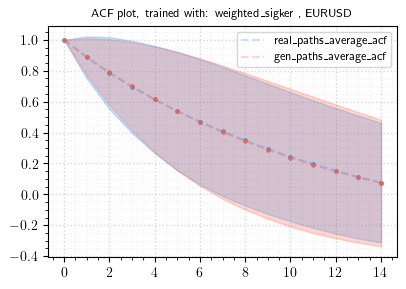

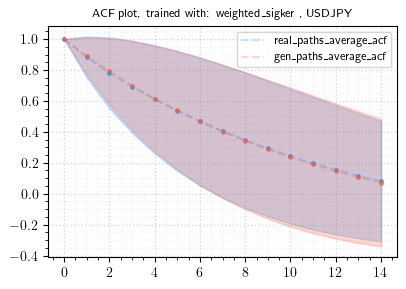

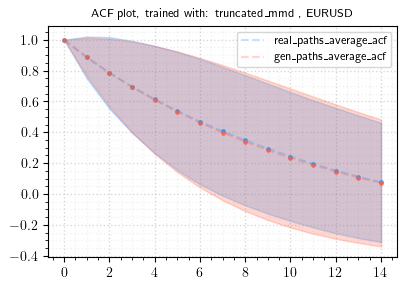

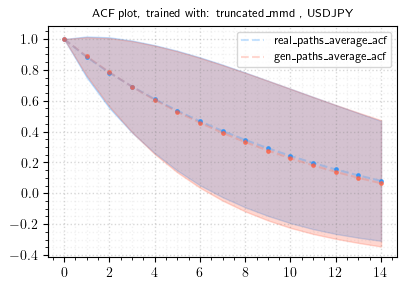

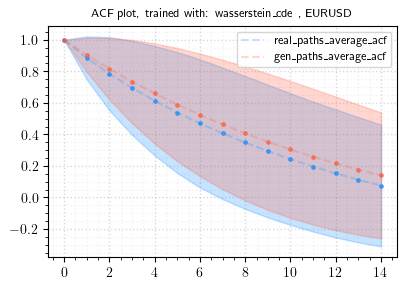

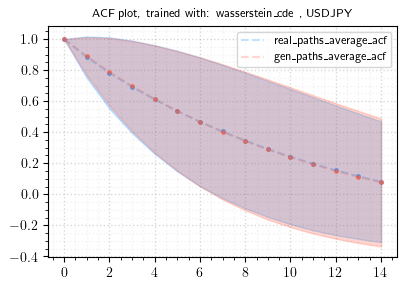

In [13]:
height = 3

for i, disc in enumerate(discriminator_types):
    
    for k in range(dims):
        
        fig, ax = plt.subplots(1, 1, figsize=(1.5*height, height))
    
        ax.plot(test_acf_means[k], color="dodgerblue", alpha=0.25, linestyle="dashed", label="real_paths_average_acf")
        ax.fill_between(acf_lags, rlcis[k], rucis[k], color="dodgerblue", alpha=0.25)

        ax.plot(gen_acf_means[i, k] , color="tomato", alpha=0.25, linestyle="dashed", label="gen_paths_average_acf")
        ax.fill_between(acf_lags, glcis[i, k], gucis[i, k], color="tomato", alpha=0.25)

        ax.scatter(np.arange(n_lags+1), test_acf_means[k], color="dodgerblue", alpha=0.75, s=6)
        ax.scatter(np.arange(n_lags+1), gen_acf_means[i, k], color="tomato", alpha=0.75, s=6)

        make_grid(axis=ax)
        ax.legend(fontsize="small");
        
        title = " , " + forex_pairs[k] if data_type == "forex" else ""
        
        ax.set_title(f"ACF plot, trained with: {disc}" + title, fontsize="small")
        
#plt.tight_layout()

## 4. Cross-covariance between $r_t, r^2_t$

Finally we plot the cross-covariance matrix between the generated and real $(r_t, r^2_t)$.

In [14]:
# Load some sample paths, perform transformations, put onto the cpu 
real_samples,     = next(iter(dataloader))
real_samples      = subtract_initial_point(real_samples).detach().cpu()

dims              = int(real_samples.size(-1) - 1)

total_generated_samples = torch.zeros([3] + list(real_samples.size()))

for i, generator in enumerate(generators):
    total_generated_samples[i] = subtract_initial_point(generator(ts, eval_batch_size)).detach().cpu()

weighted_sigker MSE: 0.039933
truncated_mmd MSE: 0.020257
wasserstein_cde MSE: 0.066645
weighted_sigker MSE: 0.069258
truncated_mmd MSE: 0.050259
wasserstein_cde MSE: 0.045685


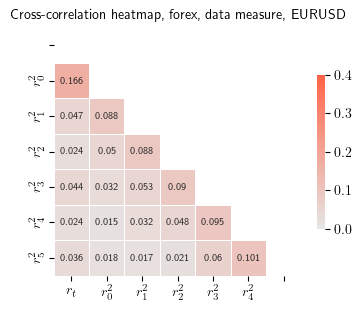

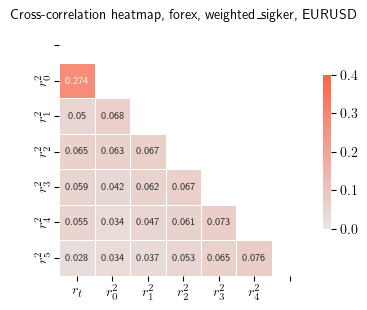

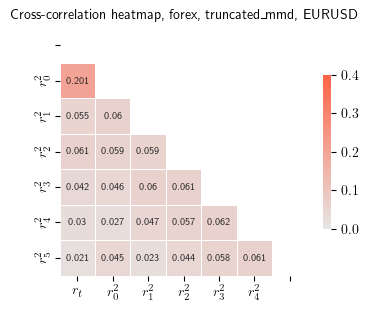

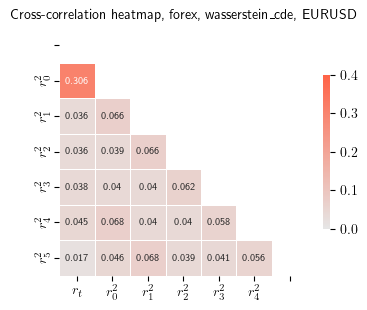

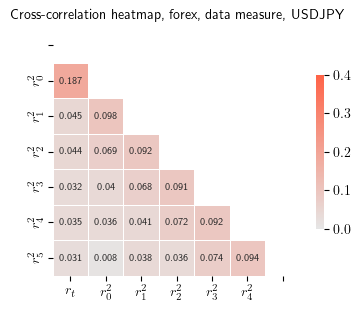

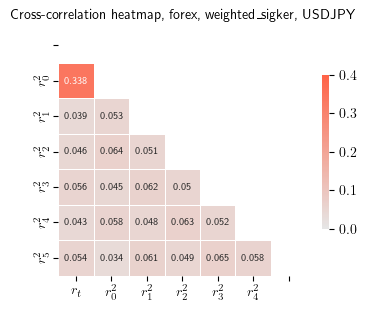

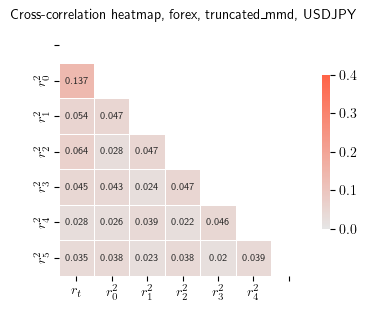

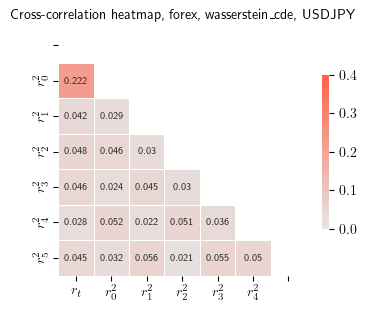

In [15]:
lags = (0, 1, 2, 3, 4, 5, 6)
columns = ["$r_t$"] + [f"$r^2_{l}$"for l in lags[:-1]]
xcolumns = columns[:-1] + [""]
ycolumns = [""] + columns[1:]

for k in range(dims):
    
    real_ccov_paths = torch.zeros((batch_size, path_length-1, 2))

    real_ret_paths          = (real_samples[..., 1:, k+1]+1)/(real_samples[..., :-1, k+1]+1) - 1
    real_ret_sq_paths       = real_ret_paths**2
    real_ccov_paths[..., 0] = real_ret_paths
    real_ccov_paths[..., 1] = real_ret_sq_paths
    real_ccor_matrix        = get_ccor_matrix(real_ccov_paths, lags=lags)

    gen_ccov_paths = torch.zeros((3, batch_size, path_length-1, 2))

    for i, generated_samples in enumerate(total_generated_samples):

        gen_ret_paths     = (generated_samples[..., 1:, k+1]+1)/(generated_samples[..., :-1, k+1]+1) - 1
        gen_ret_sq_paths  = gen_ret_paths**2

        gen_ccov_paths[i, ..., 0] = gen_ret_paths
        gen_ccov_paths[i, ..., 1] = gen_ret_sq_paths

    gen_ccor_matrices = np.zeros([3] + list(real_ccor_matrix.shape))

    for i, g_ccov_paths in enumerate(gen_ccov_paths):
        gen_ccor_matrices[i] = get_ccor_matrix(g_ccov_paths, lags=lags)

    fig, ax   = plt.subplots(1, 1, figsize=(4, 4))
    
    title = ", " + forex_pairs[k] if data_type == "forex" else ""

    plot_matrix = pd.DataFrame(np.round(real_ccor_matrix, 3), columns=columns)

    mask = np.triu(np.ones_like(plot_matrix, dtype=bool))
    cmap = sns.blend_palette(["dodgerblue", ".9", "tomato"], as_cmap=True)

    sns.heatmap(plot_matrix, mask=mask, annot=True, fmt='g', cmap=cmap, center=0, 
                ax=ax, square=True, linewidths=.5, vmin=0, vmax=0.4, xticklabels=xcolumns, yticklabels=ycolumns,
                annot_kws={"size": 7}, cbar_kws={"shrink": .5})
    ax.set_title(f"Cross-correlation heatmap, {data_type}, data measure" + title,fontsize=10)

    for i, gen_ccor_matrix in enumerate(gen_ccor_matrices):
        
        fig, ax   = plt.subplots(1, 1, figsize=(4, 4))
        plot_matrix = pd.DataFrame(np.round(gen_ccor_matrix, 3), columns=columns)

        sns.heatmap(plot_matrix, mask=mask, annot=True, fmt='g', cmap=cmap, center=0, 
                    ax=ax, square=True, linewidths=.5, vmin=0, vmax=0.4, xticklabels=xcolumns, yticklabels=ycolumns,
                    annot_kws={"size": 7}, cbar_kws={"shrink": .5})
        ax.set_title(f"Cross-correlation heatmap, {data_type}, {discriminator_types[i]}" + title,fontsize=10)

    for i, gen_ccor_matrix in enumerate(gen_ccor_matrices):

        mse = torch.sum(torch.pow(real_ccor_matrix - gen_ccor_matrix, 2)).item()

        print(f"{discriminator_types[i]} MSE: {mse:.6f}")

In [10]:
n_repeats = 8
batch_size, length, dim = real_samples.size()

n_bins = int(n_repeats*eval_batch_size/20)

In [11]:
tot_real_samples  = torch.empty((0, length, dim))
total_gen_samples = torch.empty((3, int(n_repeats*eval_batch_size), length, dim))

with torch.no_grad():
    for _ in range(n_repeats):
        real_samples,     = next(iter(dataloader))
        real_samples      = subtract_initial_point(real_samples).detach().cpu()
        
        tot_real_samples = torch.cat([tot_real_samples, real_samples], dim=0)

    for i, generator in enumerate(generators):
        tot_gen_samples = torch.empty((0, length, dim))
        for _ in range(n_repeats):
            gen_samples        = subtract_initial_point(generator(ts, eval_batch_size)).cpu()     
            tot_gen_samples = torch.cat([tot_gen_samples, gen_samples], dim=0)
            
        total_gen_samples[i] = tot_gen_samples

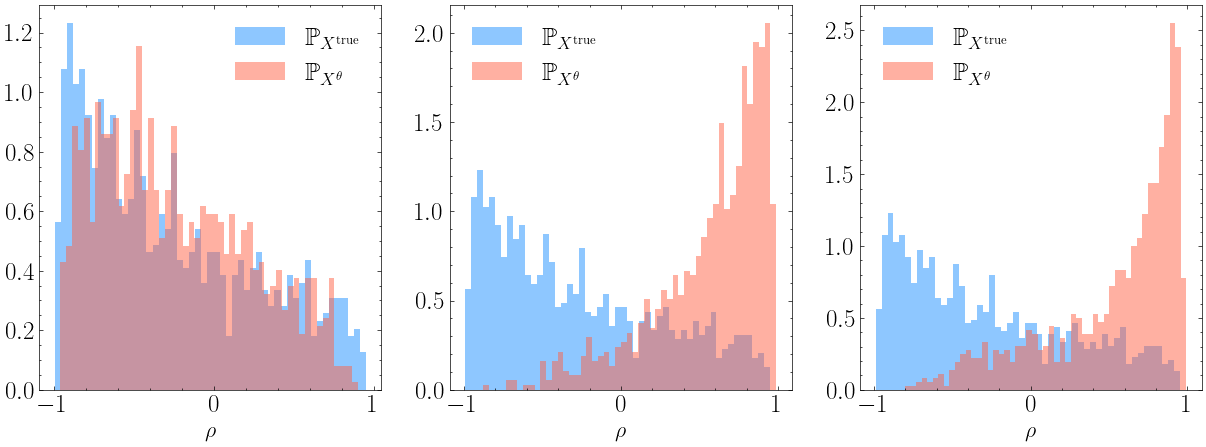

In [12]:
_discriminator_types = [r"$\phi_{\text{sig}}$", r"$\phi^N_{\text{sig}}$", "SDE-GAN"]

if data_type == "forex":
    # Provide correlation of paths as well
    real_corrcoefs = np.array([
        np.corrcoef(r1, r2)[0,1] for r1, r2 in zip(tot_real_samples[:, 1:, 1], tot_real_samples[:, 1:, 2])
    ])
    
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    
    for k, (axi, generated_samples) in enumerate(zip(ax, total_gen_samples)):
        
        
        gen_corrcoefs = np.array([
            np.corrcoef(r1, r2)[0,1] for r1, r2 in zip(generated_samples[:, 1:, 1], generated_samples[:, 1:, 2])
        ])
        
        axi.hist(
            real_corrcoefs, bins=n_bins, color="dodgerblue", alpha=0.5, density=True, label=r"$\mathbb{P}_{X^{\text{true}}}$"
        )
        
        axi.hist(
            gen_corrcoefs, bins=n_bins, color="tomato", alpha=0.5, density=True, label=r"$\mathbb{P}_{X^\theta}$"
        )
        
        #make_grid(axis=axi)
        
        #ax.set_title(f"Correlation coefficient distribution, {_discriminator_types[k]}", fontsize="large")
        axi.set_xlabel(r"$\rho$", fontsize=16)
        axi.legend(fontsize=18)
plt.savefig('corrcoefs.png', dpi=100)